## Description:

    Diversity estimates



In [1]:

%load_ext rpy2.ipython

In [53]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(dplyr)
library(tidyr)
library(lme4)
library(lmerTest)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘lmerTest’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:lme4’:

    lmer


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:stats’:

    step


  res = super(Function, self).__call__(*new_args, **new_kwargs)


# Loading phyloseq object

In [41]:
%%R
F = file.path('/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3')
physeq.Full = readRDS(F)
sd = sample_data(physeq.Full)
physeq.Full

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 238 samples ]
sample_data() Sample Data:       [ 238 samples by 49 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


### Rarefy to minimum number of reads

In [57]:
%%R
sample_sums(physeq.Full) %>% min

[1] 4989


In [58]:
%%R
set.seed(605)
physeq.r = rarefy_even_depth(physeq.Full)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: You set `rngseed` to FALSE. Make sure you've set & recorded
 the random seed of your session for reproducibility.
See `?set.seed`


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: ...

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [42]:
%%R
colnames(sample_data(physeq.Full))

 [1] "X.sample"            "Library"             "Primer_Plate"       
 [4] "Primer_Well_ID"      "primerFR_ID_byPlate" "primerFR_ID_total"  
 [7] "barcode_ID"          "PlotID"              "Plant"              
[10] "Plot"                "Treatment"           "Rep"                
[13] "DAP"                 "Sampling"            "PlantSample"        
[16] "Type"                "Grass_Broad"         "Status"             
[19] "Subfamily"           "fwd_barcode"         "rev_barcode"        
[22] "Planted"             "Biomass_P"           "SLA"                
[25] "Leaf_N"              "Leaf_C"              "LeafC_N"            
[28] "LNa"                 "Plant_N"             "Plant_C"            
[31] "Plant_CN"            "d15N"                "tN_p"               
[34] "BX_activity_g"       "CB_activity_g"       "LAP_activity_g"     
[37] "NAG_activity_g"      "BX_rel"              "CB_rel"             
[40] "LAP_rel"             "NAG_rel"             "NO3_ug_g"           
[43] "

# Alpha Diversity

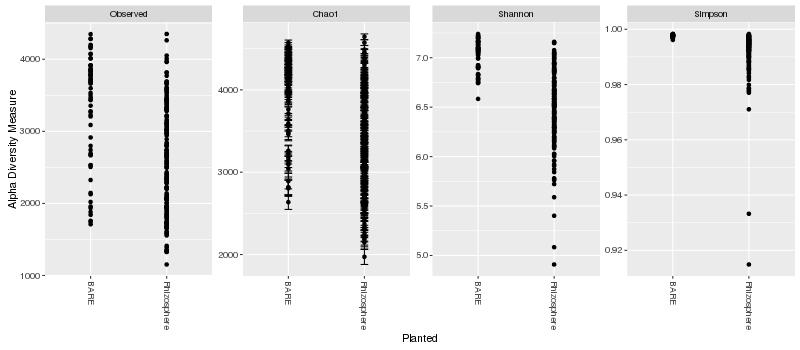

In [43]:
%%R -w 800 -h 350
alpha_meas = c("Observed", "Chao1", "Shannon", "Simpson")
(p <- plot_richness(physeq.Full, "Planted", measures=alpha_meas))

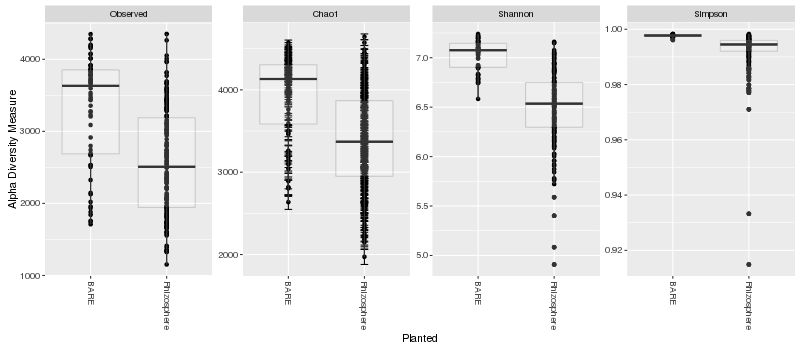

In [45]:
%%R -w 800 -h 350
p = p + geom_boxplot(data=p$data, aes(x=Planted, y=value, color=NULL), alpha=0.1)
p

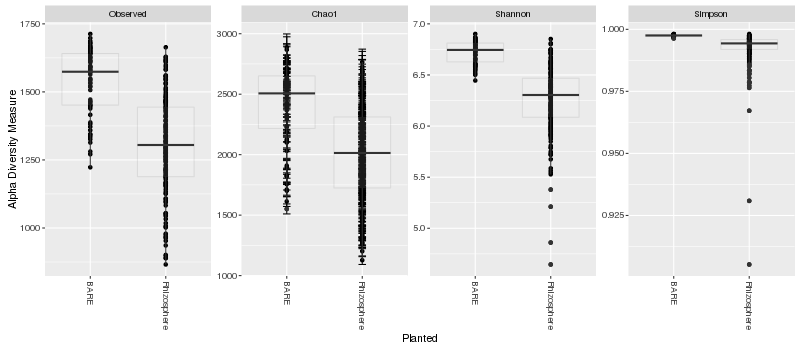

In [59]:
%%R -w 800 -h 350
alpha_meas = c("Observed", "Chao1", "Shannon", "Simpson")
p = plot_richness(physeq.r, "Planted", measures=alpha_meas)
p = p + geom_boxplot(data=p$data, aes(x=Planted, y=value, color=NULL), alpha=0.1)
p

## Estimate richness

In [60]:
%%R
#full object
Shannon = estimate_richness(physeq.Full, measures="Shannon")

sd = sample_data(physeq.Full) %>% tbl_df()

sd = bind_cols(sd, Shannon)
sd$Rep = as.factor(sd$Rep)
sd$Plant = as.factor(sd$Plant)

#rareified object
Shannon.r = estimate_richness(physeq.r, measures="Shannon")

sd.r = sample_data(physeq.r) %>% tbl_df()

sd.r = bind_cols(sd.r, Shannon.r)
sd.r$Rep = as.factor(sd.r$Rep)
sd.r$Plant = as.factor(sd.r$Plant)

In [63]:
%%R
#test library effects on microbial diversity

fit1 = lmer(Shannon~ DAP + (1|Rep) + (1|Rep:Plant), data = sd, subset = Planted == "BARE")
summary(fit1) %>% print

fit2 = lmer(Shannon~ DAP + (1|Rep) + (1|Rep:Plant), data = sd.r, subset = Planted == "BARE")
summary(fit2) %>% print

Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: Shannon ~ DAP + (1 | Rep) + (1 | Rep:Plant)
   Data: sd
 Subset: Planted == "BARE"

REML criterion at convergence: -56.3

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.46367 -0.71424  0.00474  0.66207  2.01739 

Random effects:
 Groups    Name        Variance  Std.Dev. 
 Rep       (Intercept) 0.000e+00 0.000e+00
 Rep:Plant (Intercept) 4.177e-18 2.044e-09
 Residual              1.885e-02 1.373e-01
Number of obs: 64, groups:  Rep, 4; Rep:Plant, 4

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)  7.329669   0.070862 62.000000 103.435  < 2e-16 ***
DAP         -0.004633   0.001038 62.000000  -4.464 3.46e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
    (Intr)
DAP -0.970
Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees o

In [181]:
%%R
#test sample type effects on microbial diversity

fit1 = lmer(Shannon~ Planted + DAP  + (1|Rep)  + (1|Rep:Plant), data = sd)
summary(fit1) %>% print
anova(fit1) %>% print

fit2 = lmer(Shannon~ Planted + (1|Rep) + (1|Rep:Plant), data = sd.r)
summary(fit2) %>% print
anova(fit2) %>% print

Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: Shannon ~ Planted + DAP + (1 | Rep) + (1 | Rep:Plant)
   Data: sd

REML criterion at convergence: 111.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.4417 -0.4946  0.1222  0.5673  2.4731 

Random effects:
 Groups    Name        Variance Std.Dev.
 Rep:Plant (Intercept) 0.074222 0.27244 
 Rep       (Intercept) 0.000638 0.02526 
 Residual              0.050280 0.22423 
Number of obs: 238, groups:  Rep:Plant, 91; Rep, 4

Fixed effects:
                     Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)          7.249008   0.167423  89.350000  43.297  < 2e-16 ***
PlantedRhizosphere  -0.498839   0.143412  51.610000  -3.478  0.00103 ** 
DAP                 -0.003416   0.001394 229.610000  -2.450  0.01503 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) PlntdR
PlntdRhzsph -0.

* DAP seems to have a significant effect on raw data, rarefied data DAP is not significant
* Nitrogen treatment was not significant and removed from the model
* Should this be done without filtering?  Phyloseq authors suggest so, but maybe other papers do it post filter
* Rhizosphere samples have significantly less diversity or evenness than bulk soil


In [179]:
%%R
sd.p = filter(sd, Plant != "BARE")
sd.r.p = filter(sd.r, Plant != "BARE")

fit1 = lmer(Shannon~ Plant  + (1|Rep) + (1|Rep:Plant), data = sd.p)
summary(fit1) %>% print
anova(fit1) %>% print

fit2 = lmer(Shannon~ Plant +  (1|Rep) + (1|Rep:Plant), data = sd.r.p)
summary(fit2) %>% print
anova(fit2) %>% print

Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: Shannon ~ Plant + (1 | Rep) + (1 | Rep:Plant)
   Data: sd.p

REML criterion at convergence: 106.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.2874 -0.3580  0.0127  0.4947  1.8634 

Random effects:
 Groups    Name        Variance Std.Dev.
 Rep:Plant (Intercept) 0.021143 0.14541 
 Rep       (Intercept) 0.002044 0.04522 
 Residual              0.070674 0.26584 
Number of obs: 174, groups:  Rep:Plant, 87; Rep, 4

Fixed effects:
            Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)  6.74802    0.12096 63.41000  55.788  < 2e-16 ***
PlantABUTH  -0.48641    0.16805 62.02000  -2.894 0.005237 ** 
PlantAMAPO  -0.45451    0.16805 62.02000  -2.705 0.008815 ** 
PlantB73    -0.49179    0.16805 62.02000  -2.927 0.004786 ** 
PlantB97    -0.04453    0.16805 62.02000  -0.265 0.791883    
PlantECHCG  -0.60337    0.18178 62.47000  -3.319 0.001509 ** 
Pla

### Graph Shannon index by plant

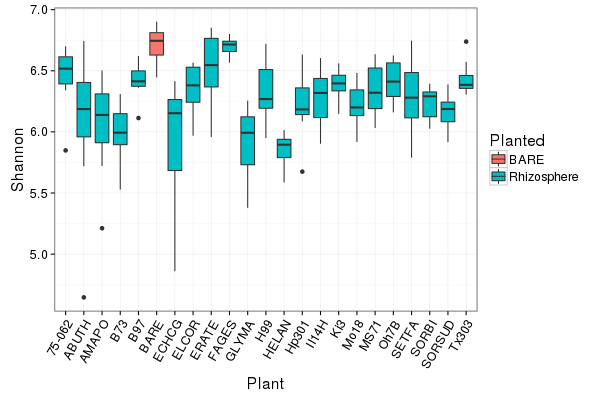

In [196]:
%%R -w 600 -h 400
p = ggplot(sd.r, aes(Plant, Shannon))
p = p + geom_boxplot(aes(fill = Planted))
p = p + theme_bw(base_size = 16)
p = p + theme(axis.text.x = element_text(angle = 60, hjust = 1))

p

# Exploratory - factors correlated with shannon index work in progress

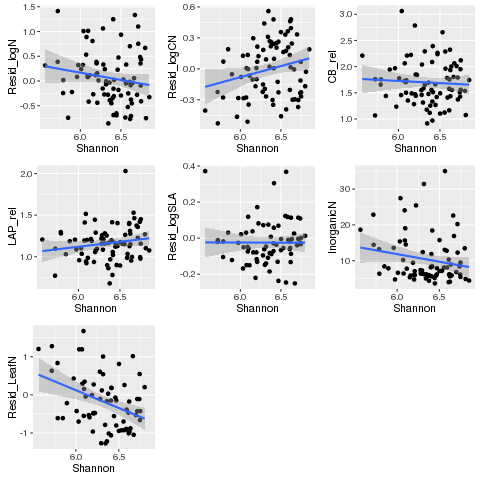

In [129]:
%%R
# remove Shannon outliers
data = sd.r.p
data = filter(sd.r.p, Shannon > 5.4)
data = filter(data, InorganicN < 50)
#data = filter(data, Treatment == "Nneg")

p = ggplot(data, aes(Shannon, Resid_logN))
p = p + geom_point()
p = p + stat_smooth(method = "lm")

p3 = ggplot(data, aes(Shannon, Resid_logCN))
p3 = p3 + geom_point()
p3 = p3 + stat_smooth(method = "lm")

p1 = ggplot(data, aes(Shannon, CB_rel))
p1 = p1 + geom_point()
p1 = p1 + stat_smooth(method = "lm")


p2 = ggplot(data, aes(Shannon, LAP_rel))
p2 = p2 + geom_point()
p2 = p2 + stat_smooth(method = "lm")

p4 = ggplot(data, aes(Shannon, Resid_logSLA))
p4 = p4 + geom_point()
p4 = p4 + stat_smooth(method = "lm")

p5 = ggplot(data, aes(Shannon, InorganicN))
p5 = p5 + geom_point()
p5 = p5 + stat_smooth(method = "lm")

p6 = ggplot(data, aes(Shannon, Resid_LeafN))
p6 = p6 + geom_point()
p6 = p6 + stat_smooth(method = "lm")

grid.arrange(p, p3, p1, p2,p4,p5, p6, ncol = 3)

In [162]:
%%R
fit3 = lmer(Shannon~InorganicN  + (1|Rep) + (1|Plant) + (1|Rep:Plant), data = data)
print("InorganicN")
anova(fit3) %>% print

fit1 = lmer(Resid_logN~Shannon + Treatment + Plant + (1|Rep) + (1|Rep:Plant), data = data)
print("Resid_logN")
anova(fit1) %>% print # Interaction of Shannon and Treatment is not significant, plant must be included in model 
# for Shannon to be significant 

fit2 = lmer(LAP_rel~Shannon + Plant + Treatment + Shannon:Plant  + (1|Rep) + (1|Rep:Plant), data = data)
print("LAP_rel")
anova(fit2) %>% print #3way interaction marginal = .08, interaction of Shannon and plant is significant



fit4 = lmer(CB_rel~Shannon + Treatment + (1|Rep) + (1|Plant)+ (1|Rep:Plant), data = data)
print("CB_rel")
anova(fit4) %>% print

fit5 = lmer(Shannon~Resid_logCN*Treatment + (1|Rep) + (1|Plant)+ (1|Rep:Plant), data = data)
anova(fit5) %>% print

fit6 = lmer(Shannon~Type*Treatment + (1|Rep) + (1|Plant)+ (1|Rep:Plant), data = data)
anova(fit6) %>% print


fit7 = lmer(Shannon~Resid_LeafN*Treatment + (1|Rep) + (1|Plant)+ (1|Rep:Plant), data = data)
anova(fit7) %>% print


[1] "InorganicN"
Analysis of Variance Table of type III  with  Satterthwaite 
approximation for degrees of freedom
             Sum Sq  Mean Sq NumDF  DenDF F.value Pr(>F)
InorganicN 0.088811 0.088811     1 75.873  1.9735 0.1642
[1] "Resid_logN"
Analysis of Variance Table of type III  with  Satterthwaite 
approximation for degrees of freedom
          Sum Sq Mean Sq NumDF  DenDF F.value    Pr(>F)    
Shannon   0.4165 0.41647     1 66.652  5.4449  0.022652 *  
Treatment 1.2173 1.21727     1 38.509 15.9144  0.000287 ***
Plant     8.3675 0.83675    10 31.461 10.9396 1.024e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "LAP_rel"
Analysis of Variance Table of type III  with  Satterthwaite 
approximation for degrees of freedom
               Sum Sq  Mean Sq NumDF  DenDF F.value  Pr(>F)  
Shannon       0.02661 0.026610     1 56.508  1.2812 0.26245  
Plant         0.50572 0.050572    10 46.350  2.4350 0.01996 *
Treatment     0.05532 0.055322     1 32.974  2.6637